Anomaly Detection in Household Power Consumption using LSTM Autoencoders and Clustering 

This notebook explores the application of  LSTM Autoencoders for detecting anomalies in time series data. We'll be using the well-known UCI Household Electric Power Consumption dataset.

**Our Approach:**
1.  **Load & Prepare Data:** We'll start by loading the dataset, cleaning it (handling missing values), and resampling it to an hourly frequency.
2.  **LSTM Autoencoder:** We'll build an LSTM Autoencoder using PyTorch. The core idea is to train this model *only* on normal data patterns. Anomalies, being different, should cause high reconstruction errors when fed through the trained model.
3.  **Anomaly Detection:** We'll use the reconstruction error from the autoencoder as an anomaly score. A threshold, derived from the errors on normal training data, will help us flag potential anomalies in the test data.
4.  **Latent Space Clustering:** To gain deeper insights, we'll extract the compressed representations (latent vectors) learned by the autoencoder's encoder part. We'll apply K-Means clustering to these vectors to see if different types of normal behavior form distinct groups and where the anomalies lie in relation to these groups.
5.  **Visualization & Analysis:** Finally, we'll visualize the detected anomalies and the latent space clusters to understand the results.

## 1. Setup: Importing Libraries and Configuration

First, let's import all the necessary libraries. We'll need `pandas` for data manipulation, `numpy` for numerical operations, `matplotlib` for plotting, `scikit-learn` for preprocessing and clustering, and `torch` for our deep learning model.

We also define key parameters here, like the dataset filename, LSTM sequence length (`TIME_STEPS`), training epochs, batch size, the crucial `THRESHOLD_PERCENTILE` for anomaly detection, and the number of clusters (`N_CLUSTERS`) for K-Means. Setting the device (`cuda` or `cpu`) ensures our PyTorch code runs on the available hardware.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA # For visualization
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import os
import copy # For saving best model state
import warnings

# Suppress specific warnings if needed (e.g., KMeans n_init)
warnings.filterwarnings("ignore", category=FutureWarning, module='sklearn.cluster._kmeans')


# --- Configuration ---
DATASET_FILENAME = 'household_power_consumption.txt'
TIME_STEPS = 24 * 7 # Use 1 week of hourly data
EPOCHS = 50 # Adjust as needed (can be lower for quick tests)
BATCH_SIZE = 64
# --- Threshold percentile for anomaly detection --- 
THRESHOLD_PERCENTILE = 95 # Start with 95, adjust based on results (e.g., 90, 85)
N_CLUSTERS = 5 # Number of clusters for K-Means
LEARNING_RATE = 1e-3
EARLY_STOPPING_PATIENCE = 10
BEST_MODEL_PATH = 'best_lstm_ae_pytorch.pth' # Path to save the best model

# --- Device Configuration ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## 2. Data Loading and Preprocessing

Now, we load the dataset. This involves reading the `.txt` file, parsing dates and times correctly, and specifying how missing values (represented by '?') are marked.

**Data Cleaning:** Real-world data is rarely perfect. We'll convert relevant columns to numeric types and handle any missing values. A common strategy for time series is forward-filling (`ffill`) followed by back-filling (`bfill`) to ensure no gaps remain.

**Feature Selection & Resampling:** The dataset has multiple features. For this analysis, we'll focus on `Global_active_power`. Since the original data is at the minute level (over 2 million rows!), we'll resample it to hourly averages. This makes the analysis computationally feasible and smooths out high-frequency noise, focusing on broader consumption patterns.

Loading dataset: household_power_consumption.txt...


C:\Users\amanp\AppData\Local\Temp\ipykernel_33284\819649826.py:12: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(
C:\Users\amanp\AppData\Local\Temp\ipykernel_33284\819649826.py:12: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv(


Dataset loaded successfully.
Cleaning data...
Total missing values after cleaning: 0
Resampling data to hourly frequency...
Resampled data shape: (34589, 1)

Resampled Data Head:
                     Global_active_power
datetime                                
2006-12-16 17:00:00             4.222889
2006-12-16 18:00:00             3.632200
2006-12-16 19:00:00             3.400233
2006-12-16 20:00:00             3.268567
2006-12-16 21:00:00             3.056467


C:\Users\amanp\AppData\Local\Temp\ipykernel_33284\819649826.py:37: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
C:\Users\amanp\AppData\Local\Temp\ipykernel_33284\819649826.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)


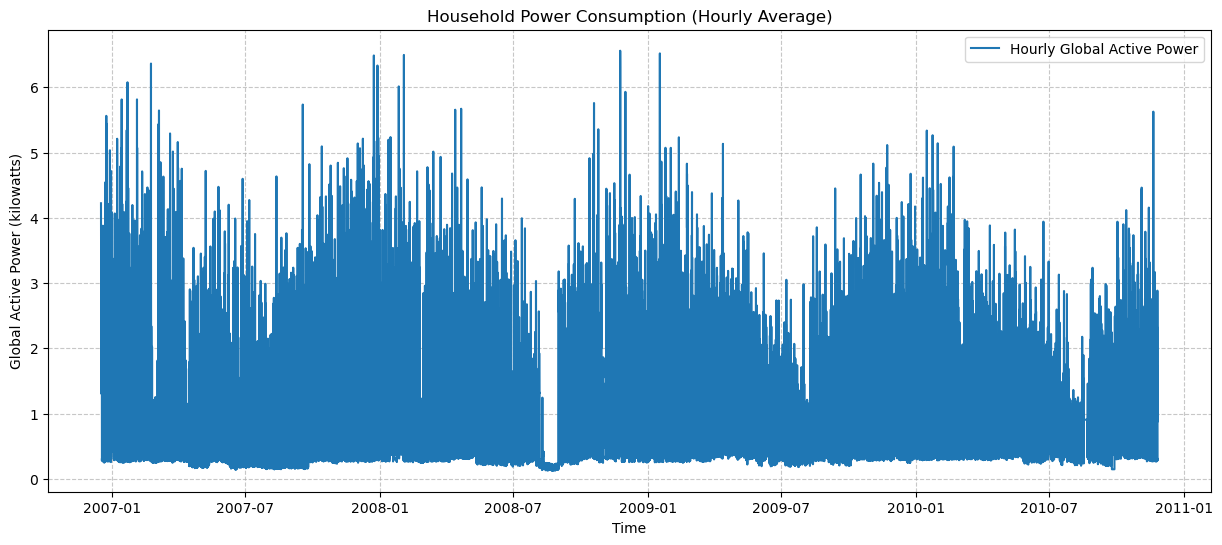

In [2]:
# --- 1. Load and Preprocess Real Data ---

# Check if the dataset file exists
if not os.path.exists(DATASET_FILENAME):
    print(f"Error: Dataset file '{DATASET_FILENAME}' not found.")
    print("Please download it from UCI ML Repository and place it in the same directory.")
    # Or raise an error: raise FileNotFoundError(f"Dataset file '{DATASET_FILENAME}' not found.")
    exit() # Exit if file not found in a script context

print(f"Loading dataset: {DATASET_FILENAME}...")
try:
    df = pd.read_csv(
        DATASET_FILENAME,
        sep=';',
        parse_dates={'datetime': ['Date', 'Time']},
        infer_datetime_format=True,
        low_memory=False,
        na_values=['nan', '?'], # Define strings to recognize as NaN
        index_col='datetime' # Set the datetime column as index
    )
    print("Dataset loaded successfully.")
except Exception as e:
    print(f"Error loading dataset: {e}")
    exit() # Exit on loading error

# --- Data Cleaning ---
print("Cleaning data...")
# Convert columns to numeric, coercing errors (non-numeric values become NaN)
for col in df.columns:
    if df[col].dtype == 'object':
         try:
             df[col] = pd.to_numeric(df[col])
         except ValueError:
            print(f"Could not convert column {col} to numeric.")

# Handle missing values (e.g., forward fill then backfill)
df.fillna(method='ffill', inplace=True)
df.fillna(method='bfill', inplace=True)
print(f"Total missing values after cleaning: {df.isnull().sum().sum()}") # Should be 0

# --- Feature Selection and Resampling ---
# Focus on 'Global_active_power' and resample to hourly mean
print("Resampling data to hourly frequency...")
df_resampled = df['Global_active_power'].resample('H').mean().to_frame()

# Check if resampling resulted in NaNs (if an hour had no data)
if df_resampled.isnull().values.any():
    print("NaNs found after resampling, filling again...")
    df_resampled.fillna(method='ffill', inplace=True)
    df_resampled.fillna(method='bfill', inplace=True)

print(f"Resampled data shape: {df_resampled.shape}")
print("\nResampled Data Head:")
print(df_resampled.head())

# Visualize the resampled data
plt.figure(figsize=(15, 6))
plt.plot(df_resampled.index, df_resampled['Global_active_power'], label='Hourly Global Active Power')
plt.title('Household Power Consumption (Hourly Average)')
plt.xlabel('Time')
plt.ylabel('Global Active Power (kilowatts)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

## 3. Data Preparation for LSTM

LSTMs, like most neural networks, work best with scaled data. We'll use `MinMaxScaler` to scale the power consumption values to the range [0, 1].

**Train/Test Split:** We'll split the data chronologically, using the earlier years for training the autoencoder (assuming this period represents mostly normal behavior) and the final year for testing its anomaly detection capabilities.

**Sequencing:** LSTMs require input in the form of sequences. We'll create overlapping windows of data (e.g., using one week's worth of hourly data per window, defined by `TIME_STEPS`).

**PyTorch Conversion:** Finally, we convert our NumPy sequence arrays into PyTorch tensors and create `DataLoader` objects. DataLoaders handle batching the data efficiently during model training and evaluation.

In [3]:
# --- 2. Data Preparation ---

# Scale the data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
df_resampled['scaled_power'] = scaler.fit_transform(df_resampled[['Global_active_power']])

# Split data: Use first ~3 years for training, last year for testing
split_date = df_resampled.index.max() - pd.DateOffset(years=1)
train_df = df_resampled.loc[df_resampled.index <= split_date].copy()
test_df = df_resampled.loc[df_resampled.index > split_date].copy()

print(f"\nTraining data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")

# Function to create sequences
def create_sequences(values, time_steps):
    """Creates overlapping sequences from time series data."""
    output = []
    if len(values) < time_steps:
        print(f"Warning: Data length ({len(values)}) is less than time steps ({time_steps}).")
        return np.empty((0, time_steps, 1)) # Ensure 3D output shape
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    # Reshape to (n_sequences, time_steps, n_features=1)
    return np.stack(output).reshape(-1, time_steps, 1)

# Create sequences from scaled data
X_train_np = create_sequences(train_df['scaled_power'].values, TIME_STEPS)
X_test_np = create_sequences(test_df['scaled_power'].values, TIME_STEPS)

# Check if sequences were created successfully
if X_train_np.shape[0] == 0 or X_test_np.shape[0] == 0:
    print("Error: Not enough data to create training or testing sequences with the chosen TIME_STEPS.")
    exit() # Or raise ValueError

print(f"\nNumpy Training sequences shape: {X_train_np.shape}")
print(f"Numpy Test sequences shape: {X_test_np.shape}")

# --- Convert to PyTorch Tensors ---
X_train = torch.tensor(X_train_np, dtype=torch.float32)
X_test = torch.tensor(X_test_np, dtype=torch.float32)

# --- Create DataLoaders ---
# Autoencoder target is the input itself
train_dataset = TensorDataset(X_train, X_train)

# Split training data for validation during training
val_split = int(0.9 * len(X_train)) # Use 10% for validation
train_subset_indices = list(range(val_split))
val_subset_indices = list(range(val_split, len(X_train)))

train_subset_dataset = TensorDataset(X_train[train_subset_indices], X_train[train_subset_indices])
val_dataset = TensorDataset(X_train[val_subset_indices], X_train[val_subset_indices])

# DataLoaders for training, validation, and testing
train_subset_loader = DataLoader(train_subset_dataset, batch_size=BATCH_SIZE, shuffle=False) # No shuffle for time series
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataset = TensorDataset(X_test) # Only need input for testing AE/Encoder
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"\nDataLoaders created:")
print(f"  Training batches: {len(train_subset_loader)}")
print(f"  Validation batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")


Training data shape: (25829, 2)
Test data shape: (8760, 2)

Numpy Training sequences shape: (25662, 168, 1)
Numpy Test sequences shape: (8593, 168, 1)

DataLoaders created:
  Training batches: 361
  Validation batches: 41
  Test batches: 135


## 4. Defining the LSTM Autoencoder Model

Here, we define the core of our deep learning approach: the LSTM Autoencoder. We use PyTorch's `nn.Module` to create a custom model class.

* **Encoder:** Consists of two LSTM layers (`lstm1`, `lstm2`) that process the input sequence and compress it into a lower-dimensional 'latent vector'. Dropout layers are added for regularization to prevent overfitting.
* **Decoder:** Takes the compressed latent vector, repeats it for each time step of the original sequence, and then uses two LSTM layers (`lstm3`, `lstm4`) to try and reconstruct the original sequence from this compressed representation.
* **Output Layer:** A final linear layer followed by a sigmoid activation function ensures the output matches the shape and scale (0-1) of the input sequence.

We also include a helper `encode` method, which allows us to easily extract just the latent vector representation for a given input sequence later for our clustering analysis.

In [4]:
# --- 3. Build LSTM Autoencoder Model (PyTorch) ---
class LSTMAutoencoder(nn.Module):
    def __init__(self, input_dim, seq_len, hidden_dim, latent_dim):
        super(LSTMAutoencoder, self).__init__()
        self.seq_len = seq_len
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim

        # --- Encoder ---
        # Takes input (batch, seq_len, input_dim)
        self.lstm1 = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.dropout1 = nn.Dropout(0.2)
        # Takes input (batch, seq_len, hidden_dim) -> outputs final hidden state as latent vector
        self.lstm2 = nn.LSTM(hidden_dim, latent_dim, batch_first=True)
        self.dropout2 = nn.Dropout(0.2)

        # --- Decoder ---
        # Takes latent vector repeated seq_len times (batch, seq_len, latent_dim)
        self.lstm3 = nn.LSTM(latent_dim, hidden_dim, batch_first=True)
        self.dropout3 = nn.Dropout(0.2)
        # Takes (batch, seq_len, hidden_dim)
        self.lstm4 = nn.LSTM(hidden_dim, hidden_dim, batch_first=True) # Output hidden matches input hidden
        self.dropout4 = nn.Dropout(0.2)

        # Output layer to reconstruct original input dimensions for each time step
        self.output_layer = nn.Linear(hidden_dim, input_dim)
        # Sigmoid activation to ensure output is between 0 and 1 (matching scaled input)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # --- Encoding ---
        # x shape: (batch_size, seq_len, input_dim)
        out, _ = self.lstm1(x)
        # out shape: (batch_size, seq_len, hidden_dim)
        out = self.dropout1(out)
        # We use the final hidden state (h_n) of the second LSTM as the latent vector.
        # LSTM output is (all_time_step_outputs, (final_hidden_state, final_cell_state))
        # final_hidden_state shape: (num_layers * num_directions, batch, hidden_size) -> (1, batch, latent_dim) for us
        _, (h_n, _) = self.lstm2(out)
        # Squeeze to get (batch_size, latent_dim)
        latent_vector = h_n.squeeze(0)

        # --- Decoding ---
        # Repeat the latent vector for each time step to feed into the decoder LSTM
        # Shape required: (batch_size, seq_len, latent_dim)
        latent_vector_for_decoder = latent_vector.unsqueeze(1).repeat(1, self.seq_len, 1)

        out, _ = self.lstm3(latent_vector_for_decoder)
        out = self.dropout3(out)
        out, _ = self.lstm4(out)
        out = self.dropout4(out)
        # out shape: (batch_size, seq_len, hidden_dim)

        # Apply the output linear layer to each time step
        reconstruction = self.output_layer(out) # Shape: (batch_size, seq_len, input_dim)
        reconstruction = self.sigmoid(reconstruction) # Apply sigmoid

        # Return both reconstruction and the latent vector
        return reconstruction, latent_vector

    def encode(self, x):
        # Helper method to get just the latent vector during inference
        with torch.no_grad():
            self.eval() # Ensure model is in evaluation mode (disables dropout etc.)
            out, _ = self.lstm1(x)
            # No dropout needed for inference if using self.eval() generally, but being explicit
            # out = self.dropout1(out) # Typically dropout is disabled by .eval()
            _, (h_n, _) = self.lstm2(out)
            latent_vector = h_n.squeeze(0)
            return latent_vector


# Instantiate the model, define loss and optimizer
input_dim = 1 # Number of features (Global_active_power)
hidden_dim = 128 # Size of LSTM hidden layers
latent_dim = 64 # Size of the bottleneck latent space

model = LSTMAutoencoder(input_dim, TIME_STEPS, hidden_dim, latent_dim).to(device)
criterion = nn.L1Loss(reduction='mean') # MAE Loss is often robust for anomaly detection
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print("\n--- PyTorch Model Architecture ---")
print(model)
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal trainable parameters: {num_params}")


--- PyTorch Model Architecture ---
LSTMAutoencoder(
  (lstm1): LSTM(1, 128, batch_first=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (lstm2): LSTM(128, 64, batch_first=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (lstm3): LSTM(64, 128, batch_first=True)
  (dropout3): Dropout(p=0.2, inplace=False)
  (lstm4): LSTM(128, 128, batch_first=True)
  (dropout4): Dropout(p=0.2, inplace=False)
  (output_layer): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

Total trainable parameters: 348289


## 5. Training the Autoencoder

Now we train the model. The key is that we train it **only on the training data**, which we assume represents normal behavior. The autoencoder's goal is to minimize the reconstruction error (we use Mean Absolute Error - MAE) between its input and its output.

The training loop iterates through the specified number of `EPOCHS`. In each epoch:
1.  The model processes batches of training data (`model.train()`).
2.  For each batch, we perform a forward pass, calculate the loss, compute gradients (`loss.backward()`), and update the model weights (`optimizer.step()`).
3.  After processing all training batches, we evaluate the model on a separate validation set (`model.eval()`, `torch.no_grad()`). This gives an unbiased estimate of how well the model generalizes to data it hasn't been directly trained on.
4.  **Early Stopping:** We monitor the validation loss. If it doesn't improve for a certain number of epochs (`EARLY_STOPPING_PATIENCE`), we stop training to prevent overfitting and save the model weights from the epoch with the best validation loss.

Finally, we plot the training and validation loss curves to visually inspect the training process.


Training the autoencoder model...
Epoch [1/50], Train Loss: 0.117758, Val Loss: 0.112915
  Validation loss improved. Best model state updated (saved to best_lstm_ae_pytorch.pth).
Epoch [2/50], Train Loss: 0.114100, Val Loss: 0.106846
  Validation loss improved. Best model state updated (saved to best_lstm_ae_pytorch.pth).
Epoch [3/50], Train Loss: 0.114582, Val Loss: 0.104742
  Validation loss improved. Best model state updated (saved to best_lstm_ae_pytorch.pth).
Epoch [4/50], Train Loss: 0.114759, Val Loss: 0.103647
  Validation loss improved. Best model state updated (saved to best_lstm_ae_pytorch.pth).
Epoch [5/50], Train Loss: 0.114874, Val Loss: 0.102940
  Validation loss improved. Best model state updated (saved to best_lstm_ae_pytorch.pth).
Epoch [6/50], Train Loss: 0.114914, Val Loss: 0.102481
  Validation loss improved. Best model state updated (saved to best_lstm_ae_pytorch.pth).
Epoch [7/50], Train Loss: 0.114935, Val Loss: 0.102195
  Validation loss improved. Best model s

C:\Users\amanp\AppData\Local\Temp\ipykernel_33284\4118221017.py:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(BEST_MODEL_PATH)) # Load f

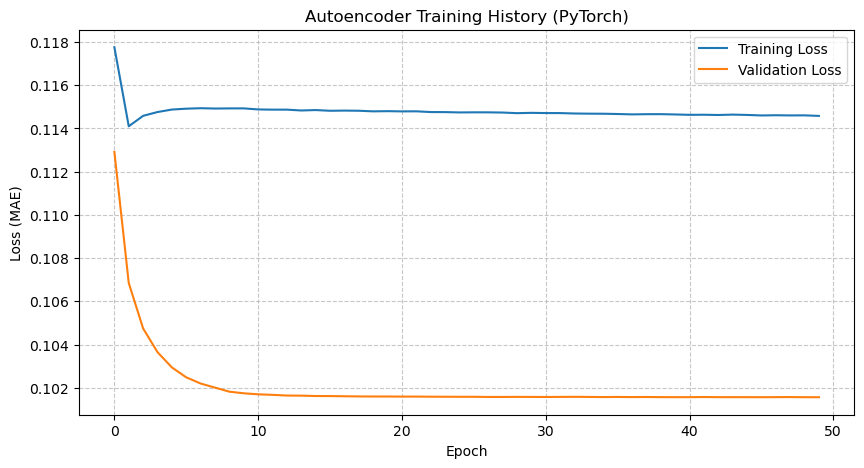

In [5]:
# --- 4. Train the Autoencoder Model (PyTorch) ---
print("\nTraining the autoencoder model...")
train_losses = []
val_losses = []
best_val_loss = float('inf')
epochs_no_improve = 0
best_model_state = None # Store the state dict of the best model

for epoch in range(EPOCHS):
    model.train() # Set model to training mode (enables dropout, etc.)
    running_train_loss = 0.0
    # Iterate over batches in the training subset loader
    for batch_features, _ in train_subset_loader: # Target is the same as input
        batch_features = batch_features.to(device) # Move data to GPU/CPU

        # --- Forward pass ---
        outputs, _ = model(batch_features) # Get reconstructions
        loss = criterion(outputs, batch_features) # Calculate loss

        # --- Backward pass and optimization ---
        optimizer.zero_grad() # Clear previous gradients
        loss.backward() # Compute gradients
        optimizer.step() # Update model weights

        running_train_loss += loss.item() * batch_features.size(0) # Accumulate loss

    # Calculate average training loss for the epoch
    epoch_train_loss = running_train_loss / len(train_subset_loader.dataset)
    train_losses.append(epoch_train_loss)

    # --- Validation Phase ---
    model.eval() # Set model to evaluation mode (disables dropout, etc.)
    running_val_loss = 0.0
    with torch.no_grad(): # Disable gradient calculations for validation
        for batch_features, _ in val_loader:
            batch_features = batch_features.to(device)
            outputs, _ = model(batch_features)
            loss = criterion(outputs, batch_features)
            running_val_loss += loss.item() * batch_features.size(0)

    # Calculate average validation loss for the epoch
    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)

    print(f'Epoch [{epoch+1}/{EPOCHS}], Train Loss: {epoch_train_loss:.6f}, Val Loss: {epoch_val_loss:.6f}')

    # --- Early Stopping Logic ---
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        epochs_no_improve = 0
        # Save the best model state dictionary (in memory)
        best_model_state = copy.deepcopy(model.state_dict())
        # Optionally save to disk immediately
        torch.save(best_model_state, BEST_MODEL_PATH)
        print(f'  Validation loss improved. Best model state updated (saved to {BEST_MODEL_PATH}).')
    else:
        epochs_no_improve += 1
        print(f'  Validation loss did not improve for {epochs_no_improve} epoch(s).')

    # Trigger early stopping if validation loss hasn't improved for patience epochs
    if epochs_no_improve >= EARLY_STOPPING_PATIENCE:
        print(f'Early stopping triggered after {epoch+1} epochs.')
        break

# --- Load Best Model ---
# Load the best model weights found during training
if best_model_state:
    print(f"\nLoading best model weights from epoch with Val Loss: {best_val_loss:.6f}")
    model.load_state_dict(torch.load(BEST_MODEL_PATH)) # Load from saved file
    # model.load_state_dict(best_model_state) # Or load from in-memory state
else:
     print("\nWarning: No best model state was saved (e.g., training stopped early or did not improve). Using the final model state.")


# --- Plot Training History ---
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Autoencoder Training History (PyTorch)')
plt.xlabel('Epoch')
plt.ylabel('Loss (MAE)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

## 6. Anomaly Detection via Reconstruction Error

With the model trained on normal data, we can now use it for anomaly detection. The process is:

1.  **Calculate Training Errors:** Pass the original *training* sequences through the trained autoencoder and calculate the reconstruction error (MAE) for each sequence. This gives us a distribution of errors representing 'normal' behavior.
2.  **Determine Threshold:** Select a threshold based on the distribution of training errors. A common approach is to use a high percentile (e.g., the 95th percentile, defined by `THRESHOLD_PERCENTILE`). This means any sequence with an error higher than 95% of the training errors will be considered potentially anomalous.
3.  **Calculate Test Errors:** Pass the *test* sequences through the autoencoder and calculate their reconstruction errors.
4.  **Identify Anomalies:** Compare the test errors to the calculated `THRESHOLD`. Any test sequence whose error exceeds the threshold is flagged as an anomaly.

We then add the calculated loss and the anomaly flag back to our test DataFrame for analysis and visualization.


Calculating reconstruction errors...
Calculated MAE for 25662 training sequences.
Anomaly Threshold (95th percentile of training loss): 0.173219


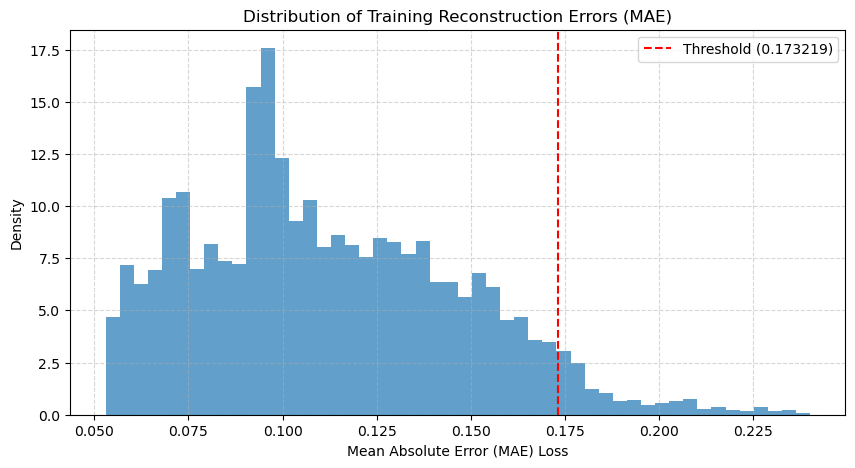

Calculated MAE for 8593 test sequences.

Total anomalies detected (Reconstruction Error): 1

Test DataFrame tail with anomaly results:
                     Global_active_power  scaled_power      loss  \
datetime                                                           
2010-11-26 17:00:00             1.725900      0.248876  0.112678   
2010-11-26 18:00:00             1.573467      0.225194  0.113192   
2010-11-26 19:00:00             1.659333      0.238534  0.113579   
2010-11-26 20:00:00             1.163700      0.161531  0.113175   
2010-11-26 21:00:00             0.934667      0.125948  0.112441   

                     anomaly_detected  threshold  
datetime                                          
2010-11-26 17:00:00             False   0.173219  
2010-11-26 18:00:00             False   0.173219  
2010-11-26 19:00:00             False   0.173219  
2010-11-26 20:00:00             False   0.173219  
2010-11-26 21:00:00             False   0.173219  


In [6]:
# --- 5. Anomaly Detection (Based on Reconstruction Error) ---
print("\nCalculating reconstruction errors...")
model.eval() # Ensure model is in evaluation mode

# --- Calculate errors on the full training set ---
train_errors = []
# Use the full training dataset (X_train) to get a robust error distribution
full_train_dataset = TensorDataset(X_train, X_train)
full_train_loader = DataLoader(full_train_dataset, batch_size=BATCH_SIZE, shuffle=False)

with torch.no_grad():
    for batch_features, _ in full_train_loader:
        batch_features = batch_features.to(device)
        reconstructions, _ = model(batch_features)
        # Calculate MAE loss per sequence in the batch
        # Mean absolute error across time steps and features for each sequence
        loss = torch.mean(torch.abs(reconstructions - batch_features), dim=(1, 2))
        train_errors.extend(loss.cpu().numpy()) # Collect errors as numpy array

train_mae_loss_np = np.array(train_errors)
print(f"Calculated MAE for {len(train_mae_loss_np)} training sequences.")

# --- Determine Anomaly Threshold ---
# Uses the THRESHOLD_PERCENTILE defined in cell 1
THRESHOLD = np.percentile(train_mae_loss_np, THRESHOLD_PERCENTILE)
print(f"Anomaly Threshold ({THRESHOLD_PERCENTILE}th percentile of training loss): {THRESHOLD:.6f}")

# Plot distribution of training reconstruction errors
plt.figure(figsize=(10, 5))
plt.hist(train_mae_loss_np, bins=50, density=True, alpha=0.7)
plt.axvline(THRESHOLD, color='r', linestyle='--', label=f'Threshold ({THRESHOLD:.6f})')
plt.title('Distribution of Training Reconstruction Errors (MAE)')
plt.xlabel('Mean Absolute Error (MAE) Loss')
plt.ylabel('Density')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# --- Calculate errors on the test set ---
test_errors = []
with torch.no_grad():
    for batch_features in test_loader: # Only need input features from test loader
        batch_features = batch_features[0].to(device) # DataLoader wraps input in a tuple
        reconstructions, _ = model(batch_features)
        loss = torch.mean(torch.abs(reconstructions - batch_features), dim=(1, 2))
        test_errors.extend(loss.cpu().numpy())

test_mae_loss_np = np.array(test_errors)
print(f"Calculated MAE for {len(test_mae_loss_np)} test sequences.")

# --- Add results back to the test DataFrame ---
# Create columns initialized with NaN
test_df['loss'] = np.nan
test_df['anomaly_detected'] = False # Initialize as boolean

# Pad the losses to match the original test_df length
# The loss for a sequence corresponds to the window ENDING at that time step
start_index_df = test_df.index[TIME_STEPS - 1] # Index of the end of the first window
end_index_df = test_df.index[TIME_STEPS - 1 + len(test_mae_loss_np) - 1] # Index of the end of the last window

# Assign loss values to the corresponding indices in the DataFrame
# Ensure the slice length matches the number of calculated losses
assign_len = min(len(test_mae_loss_np), len(test_df.loc[start_index_df:end_index_df]))
test_df.loc[start_index_df:end_index_df, 'loss'][:assign_len] = test_mae_loss_np[:assign_len]


# Determine anomalies based on the threshold
test_df['anomaly_detected'] = test_df['loss'] > THRESHOLD
test_df['threshold'] = THRESHOLD # Add threshold column for reference

print(f"\nTotal anomalies detected (Reconstruction Error): {test_df['anomaly_detected'].sum()}")
print("\nTest DataFrame tail with anomaly results:")
print(test_df.tail())

## 7. Latent Space Clustering

Beyond just detecting anomalies based on reconstruction error, we can explore the *structure* the autoencoder learned. The encoder compresses each input sequence into a lower-dimensional 'latent vector'. These vectors capture the essential characteristics of the sequences.

Here, we:
1.  **Extract Latent Vectors:** Use the `model.encode()` method to get the latent vectors for all sequences in the test set.
2.  **Apply K-Means:** Use the K-Means algorithm (from scikit-learn) to cluster these latent vectors into `N_CLUSTERS` groups. Sequences with similar characteristics should ideally fall into the same cluster.
3.  **Assign Clusters:** Add the resulting cluster labels back to the test DataFrame, aligning them with the corresponding time steps.

In [7]:
# --- 6. Latent Space Clustering ---
print("\nPerforming clustering on latent space representations...")
model.eval() # Ensure model is in eval mode

# --- Get latent vectors for the test set ---
latent_vectors_list = []
with torch.no_grad():
    for batch_features in test_loader:
        batch_features = batch_features[0].to(device)
        # Use the dedicated encode method
        latent_batch = model.encode(batch_features)
        latent_vectors_list.append(latent_batch.cpu().numpy()) # Collect as numpy arrays

# Concatenate latent vectors from all batches
latent_vectors_test_np = np.concatenate(latent_vectors_list, axis=0)
print(f"Shape of latent vectors (test set): {latent_vectors_test_np.shape}") # Should be (n_test_sequences, latent_dim)

# --- Apply K-Means clustering ---
# Use scikit-learn KMeans on the numpy array of latent vectors
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=42, n_init='auto') # n_init='auto' suppresses warning
clusters = kmeans.fit_predict(latent_vectors_test_np)
print(f"K-Means clustering complete. Found {len(np.unique(clusters))} clusters.")

# --- Add cluster information back to the test dataframe ---
# Align clusters with the end of the window, similar to loss
test_df['cluster'] = np.nan # Initialize column

# Use the same indices as for loss assignment and ensure length matches
test_df.loc[start_index_df:end_index_df, 'cluster'][:assign_len] = clusters[:assign_len]


print(f"\nCluster distribution in test set (excluding NaNs):")
# Use dropna() before value_counts if you only want counts for assigned clusters
print(test_df['cluster'].dropna().value_counts().sort_index())


Performing clustering on latent space representations...
Shape of latent vectors (test set): (8593, 64)
K-Means clustering complete. Found 5 clusters.

Cluster distribution in test set (excluding NaNs):
cluster
0.0    2271
1.0    1291
2.0     444
3.0    2607
4.0    1980
Name: count, dtype: int64


## 8. Visualization and Cluster Analysis

Finally, let's visualize our findings:

1.  **Anomaly Visualization:** Plot the original test data and highlight the points flagged as anomalies by the reconstruction error threshold.
2.  **Loss Visualization:** Plot the reconstruction error over time for the test set and show the anomaly threshold line.
3.  **Cluster Visualization (PCA):** Since the latent space has many dimensions (e.g., 64), we use Principal Component Analysis (PCA) to reduce it to 2 dimensions for plotting. This allows us to visualize the clusters found by K-Means.
4.  **Cluster-Anomaly Relationship:** Analyze how the detected anomalies are distributed across the different clusters. We calculate the percentage of points within each cluster that were flagged as anomalous. This can reveal if certain types of normal behavior (represented by specific clusters) are more prone to being flagged, or if anomalies tend to form their own distinct clusters or lie far from normal clusters.

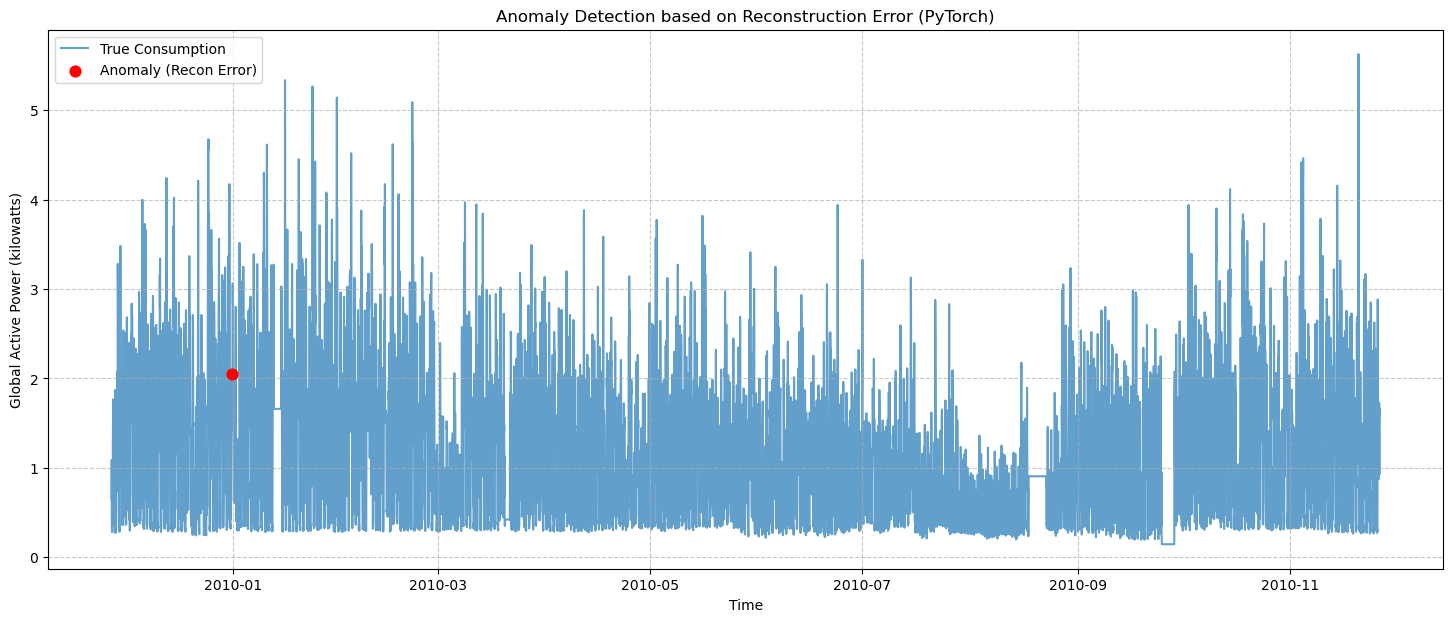

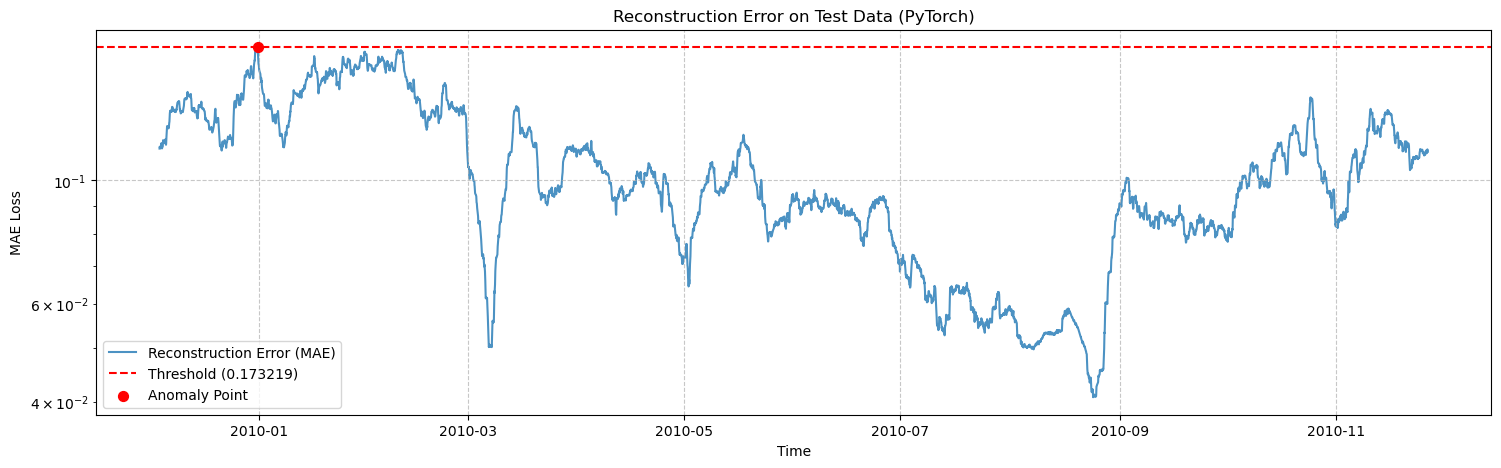


Visualizing clusters using PCA...


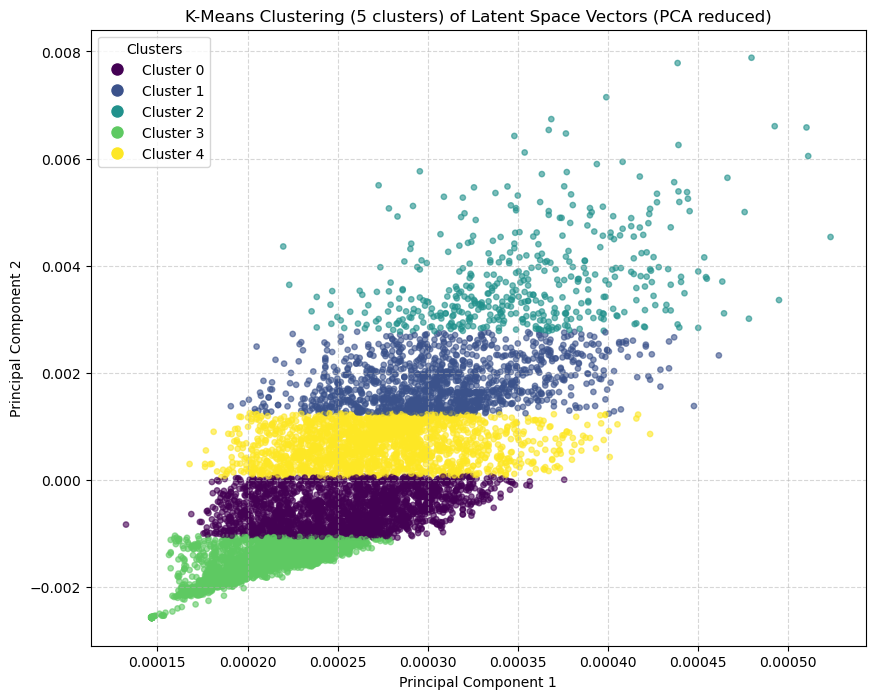


Analyzing relationship between clusters and detected anomalies...

Cluster Analysis (based on Reconstruction Error Anomalies):
   Total Windows  Anomalous Windows  Anomaly Percentage (%)
0           2271                  0                    0.00
1           1291                  1                    0.08
2            444                  0                    0.00
3           2607                  0                    0.00
4           1980                  0                    0.00


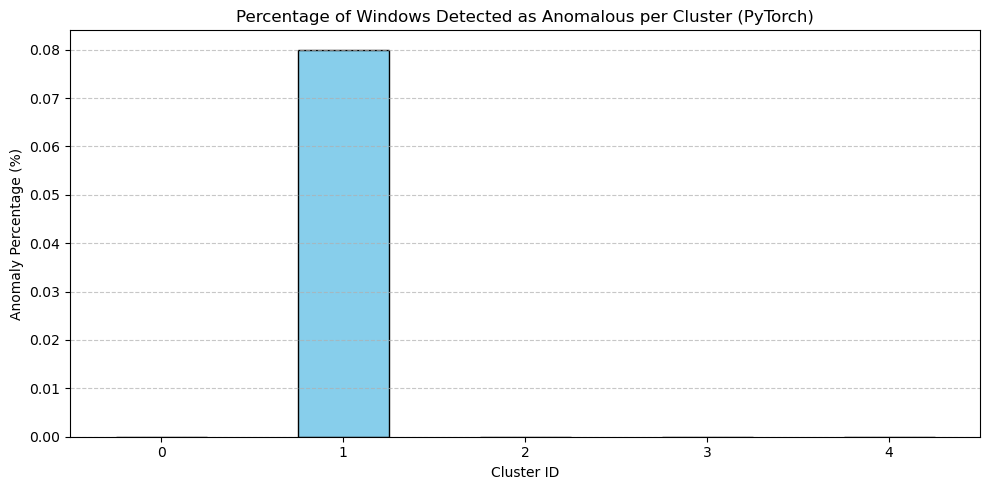


Analysis complete.


In [8]:
# --- 7. Visualization & Analysis ---

# --- Visualize Anomalies Detected by Reconstruction Error ---
plt.figure(figsize=(18, 7))
plt.plot(test_df.index, test_df['Global_active_power'], label='True Consumption', alpha=0.7, zorder=1)
# Select rows where anomaly_detected is True and loss is not NaN
detected_anomalies_recon = test_df[test_df['anomaly_detected'] & test_df['loss'].notna()]
if not detected_anomalies_recon.empty:
    plt.scatter(detected_anomalies_recon.index, detected_anomalies_recon['Global_active_power'], color='red', label='Anomaly (Recon Error)', s=60, zorder=5)
else:
    print("No anomalies detected via reconstruction error in the test set.")

plt.title('Anomaly Detection based on Reconstruction Error (PyTorch)')
plt.xlabel('Time')
plt.ylabel('Global Active Power (kilowatts)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# --- Visualize Reconstruction Loss vs Threshold ---
plt.figure(figsize=(18, 5))
# Plot only non-NaN loss values for clarity
plt.plot(test_df.index, test_df['loss'], label='Reconstruction Error (MAE)', zorder=1, alpha=0.8)
plt.axhline(THRESHOLD, color='r', linestyle='--', label=f'Threshold ({THRESHOLD:.6f})', zorder=2)
# Highlight the points where anomalies were detected
if not detected_anomalies_recon.empty:
     plt.scatter(detected_anomalies_recon.index, detected_anomalies_recon['loss'], color='red', s=50, zorder=5, label='Anomaly Point')

plt.title('Reconstruction Error on Test Data (PyTorch)')
plt.xlabel('Time')
plt.ylabel('MAE Loss')
plt.yscale('log') # Log scale often helps visualize anomalies in loss
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


# --- Visualize Clusters using PCA ---
print("\nVisualizing clusters using PCA...")
# Reduce dimensionality of latent vectors to 2D for plotting
pca = PCA(n_components=2)
latent_vectors_pca = pca.fit_transform(latent_vectors_test_np) # Use the numpy array

plt.figure(figsize=(10, 8))
# Use the 'clusters' array directly for coloring
scatter = plt.scatter(latent_vectors_pca[:, 0], latent_vectors_pca[:, 1], c=clusters, cmap='viridis', alpha=0.6, s=15)
plt.title(f'K-Means Clustering ({N_CLUSTERS} clusters) of Latent Space Vectors (PCA reduced)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
# Create legend handles
handles = [plt.Line2D([0], [0], marker='o', color='w', label=f'Cluster {i}',
                          markerfacecolor=plt.cm.viridis(i / (N_CLUSTERS -1 if N_CLUSTERS > 1 else 1)), markersize=10)
           for i in range(N_CLUSTERS)]
plt.legend(handles=handles, title="Clusters")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# --- Analyze Relationship Between Clusters and Anomalies ---
print("\nAnalyzing relationship between clusters and detected anomalies...")
# Ensure cluster column is numeric for calculations, fill NaN with a placeholder like -1
test_df['cluster_filled'] = test_df['cluster'].fillna(-1).astype(int)

# Count anomalies per cluster
anomaly_cluster_counts = test_df[test_df['anomaly_detected']]['cluster_filled'].value_counts()
# Count total points per cluster
total_cluster_counts = test_df['cluster_filled'].value_counts()

# Remove the placeholder count (-1) if it exists before analysis
anomaly_cluster_counts = anomaly_cluster_counts[anomaly_cluster_counts.index != -1].sort_index()
total_cluster_counts = total_cluster_counts[total_cluster_counts.index != -1].sort_index()

# Reindex to ensure all defined clusters (0 to N_CLUSTERS-1) are present, fill missing with 0
all_clusters_idx = pd.Index(range(N_CLUSTERS))
anomaly_cluster_counts = anomaly_cluster_counts.reindex(all_clusters_idx, fill_value=0)
total_cluster_counts = total_cluster_counts.reindex(all_clusters_idx, fill_value=0)

# Calculate anomaly percentage per cluster, handling division by zero
anomaly_percentage = (anomaly_cluster_counts.astype(float) / total_cluster_counts.replace(0, np.nan) * 100).fillna(0)

# Create a summary DataFrame
cluster_analysis = pd.DataFrame({
    'Total Windows': total_cluster_counts,
    'Anomalous Windows': anomaly_cluster_counts,
    'Anomaly Percentage (%)': anomaly_percentage.round(2) # Round for display
})

print("\nCluster Analysis (based on Reconstruction Error Anomalies):")
# Display only if there are clusters with points
if not cluster_analysis.empty:
    print(cluster_analysis)
else:
    print("No valid cluster data to analyze.")

# Visualize Anomaly Percentage per Cluster
if not cluster_analysis.empty and cluster_analysis['Total Windows'].sum() > 0 :
    plt.figure(figsize=(10, 5))
    cluster_analysis['Anomaly Percentage (%)'].plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title('Percentage of Windows Detected as Anomalous per Cluster (PyTorch)')
    plt.xlabel('Cluster ID')
    plt.ylabel('Anomaly Percentage (%)')
    plt.xticks(rotation=0)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("No cluster data to plot.")


print("\nAnalysis complete.")